# Chirp frame generator for "chirp" project

June 3 - June 5, 2018

Reference: 
- [Sound Synthesis with Numpy](https://dzone.com/articles/sound-synthesis-numpy)
- [Decoding LoRa, a Wireless
Network for the Internet of Things](https://www.rsaconference.com/writable/presentations/file_upload/hta-f01-decoding-lora-a-wireless-network-for-the-internet-of-things_copy1.pdf)
- [LoRa Reverse Engineering and AES ](https://fosdem.org/2018/schedule/event/sdr_lora_aes/attachments/slides/2357/export/events/attachments/sdr_lora_aes/slides/2357/LoRa_AES_Security_SDR_FOSDEM_2018.pdf)

In [1]:
%matplotlib inline

from numpy import linspace, sin, cos, exp, pi, int16, append, abs, angle, ceil, argmax, real, random, array
from scipy.io.wavfile import write
from scipy.signal import spectrogram, welch, butter, lfilter
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas

TQ: Time Quantum, as specified in the CAN-bus spec. 

In this implementation, chirp is sent within TQ.

In [2]:
SAMPLING_RATE = 44100  # Hz
TQ = 0.0205 # Time quantum in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = 17000
F2 = 18000

## Chirp tone synthesis

In [3]:
# Real version of chirp tone synthesis
def chirp(f1, f2, length, amp=1, rate=SAMPLING_RATE, updown="up"):
    t = linspace(0, length, int(length * rate))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    data = sin(2 * pi * freq * t) * amp
    return data.astype(int16) # two byte integers

# Complex version of chirp tone synthesis
def chirp_complex(f1, f2, length, amp=1, rate=SAMPLING_RATE, updown="up", init_phase=pi/2.0):
    t = linspace(0, length, int(length * rate))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    phase = 2 * pi * freq * t + init_phase
    return (cos(phase) + 1j * sin(phase)) * amp
#    return exp(1j * phase) * amp

def white_noise(length, rate=SAMPLING_RATE, amp=1):
    a = random.random(int(length * rate)) * 2 * amp - amp
    b = random.random(int(length * rate)) * 2 * amp - amp
    return a + 1j * b

def constant_noise(freq, length, rate=SAMPLING_RATE, amp=1):
    t = linspace(0, length, int(length * rate))
    phase = 2 * pi * freq * t
    return exp(1j * phase) * amp    

## Chirp signal

In [4]:
# Chirps two times within TQ (real version)
def chirps_in_tq(level, updown="up", amp=AMPLITUDE):
    tone = None
    if level >= 1:
        tone = chirp(F1, F2, TQ, amp, updown=updown)
    else:
        tone = chirp(0, 0, TQ, amp, updown=updown)
    return tone

# Chirps two times within TQ (complex version)
def chirps_in_tq_complex(level, updown="up", amp=AMPLITUDE, phase=pi/2.0):
    tone = None
    if level >= 1:
        tone = chirp_complex(F1, F2, TQ, amp, updown=updown, init_phase=phase)
    else:
        tone = chirp_complex(0, 0, TQ, amp, updown=updown, init_phase=phase)
    return tone
    
HIGH = 1 # HIGH means one-time chirping within TQ
LOW = 0 # LOW means no chirps within TQ (silent)

TQ_HIGH = chirps_in_tq(HIGH)
TQ_LOW = chirps_in_tq(LOW)
TQ_HIGH_DOWN = chirps_in_tq(HIGH, updown="down", amp=1)
TQ_HIGH_COMPLEX = chirps_in_tq_complex(HIGH, updown="up", amp=1)
TQ_LOW_COMPLEX = chirps_in_tq_complex(LOW, updown="up", amp=1)
TQ_HIGH_DOWN_COMPLEX = chirps_in_tq_complex(HIGH, updown="down", amp=1)

# FFT of original signal
CONSTANT_NOISE_FREQ = F1 + (F2-F1)/2
tq_high = append(TQ_HIGH[100:], TQ_HIGH[:100])
#orig_signal = tq_high +\
#    white_noise(TQ, amp=AMPLITUDE*8) +\
#    constant_noise(CONSTANT_NOISE_FREQ, TQ, amp=AMPLITUDE)
orig_signal = tq_high +\
    real(white_noise(TQ, amp=AMPLITUDE*3)) +\
    real(constant_noise(CONSTANT_NOISE_FREQ, TQ, amp=AMPLITUDE))
#orig_signal = \
#    real(white_noise(TQ, amp=AMPLITUDE*7)) +\
#    real(constant_noise(CONSTANT_NOISE_FREQ, TQ, amp=AMPLITUDE))

#print(len(df["Amplitude"]))
#orig_signal = append(df["Amplitude"], array([0,0]))

y = fftshift(fft(orig_signal))

# FFT of down chirp and conjugate chirp
y_conj = fftshift(fft(TQ_HIGH_COMPLEX.conjugate()))
y_down = fftshift(fft(TQ_HIGH_DOWN_COMPLEX))
y_down_conj = fftshift(fft(TQ_HIGH_DOWN_COMPLEX.conjugate()))

# FFT of original chirp * down chirp and original chirp * conjugate chirp 
mult_down = fftshift(fft(orig_signal * TQ_HIGH_DOWN_COMPLEX))
mult_conj = fftshift(fft(orig_signal * TQ_HIGH_COMPLEX.conjugate()))
mult_down_conj = fftshift(fft(orig_signal * TQ_HIGH_DOWN_COMPLEX.conjugate()))

# IFFT
y_mult_down = ifft(fft(orig_signal * TQ_HIGH_DOWN_COMPLEX))

# Amplitude
a = abs(y)
a_conj = abs(y_conj)
a_down = abs(y_down)
a_down_conj = abs(y_down_conj)
a_mult_conj = abs(mult_conj)
a_mult_down = abs(mult_down)

# Phase
p = angle(y)
p_conj = angle(y_conj)
p_down = angle(y_down)
p_mult_conj = angle(mult_conj)
p_mult_down = angle(mult_down)

print("Number of samples: {}".format(len(y)))
freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

Number of samples: 904


## Sample frames for testing the device

In [5]:
FRAME_FIELD_LENGTH = {"START_OF_FRAME": 3, "BITS": 2}
TRAILER = 8

def field(level, length):
    tone = None
    tone_ = None
    if level == HIGH or level == '1':
        tone = TQ_HIGH
        tone_ = TQ_HIGH
    else:
        tone = TQ_LOW
        tone_ = TQ_LOW
    for i in range(length - 1):
        tone = append(tone, tone_)
    return tone

def frame(bits):
    
    field_ = field(HIGH, FRAME_FIELD_LENGTH["START_OF_FRAME"])
    bit_field_length = FRAME_FIELD_LENGTH["BITS"] 
    for bit in bits:
        field_ = append(field_, field(bit, bit_field_length))    
    field_ = append(field_, field(LOW, TRAILER))
           
    return field_

## ASCII code "S"

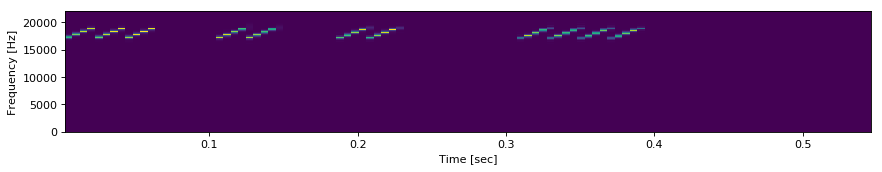

In [6]:
ascii = ord('S')
ASCII_S = list("{0:08b}".format(ascii))

#ASCII_S = [0, 1, 0, 1, 0, 0, 1, 1]

tone = frame(ASCII_S)

#plt.plot(tone)

plt.figure(figsize=(13, 2), dpi=80)
f, t, Sxx = spectrogram(tone, fs=SAMPLING_RATE)
#f, Pxx = welch(tone, fs=SAMPLING_RATE)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [7]:
WAV_FILE = 'ChirpFrameS.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## ASCII codes "Hello World!"

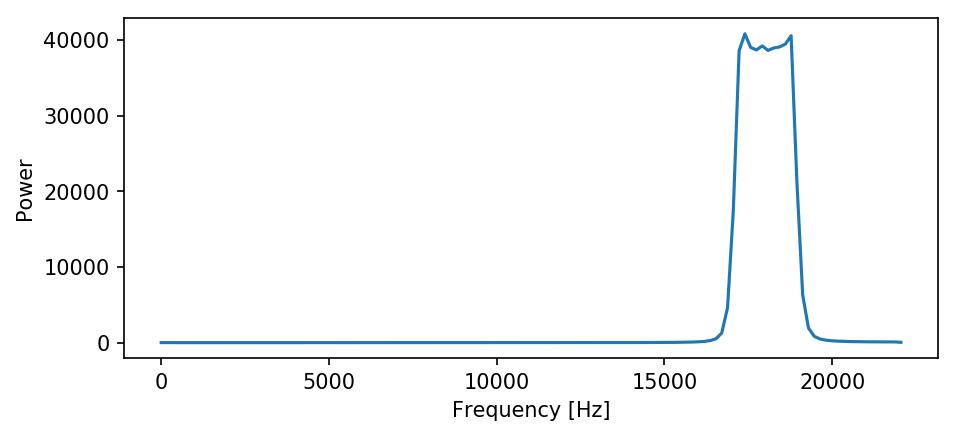

In [8]:
ascii = ord('H')
tone_H = frame(list("{0:08b}".format(ord('H'))))
tone_e = frame(list("{0:08b}".format(ord('e'))))
tone_l = frame(list("{0:08b}".format(ord('l'))))
tone_o = frame(list("{0:08b}".format(ord('o'))))
tone__ = frame(list("{0:08b}".format(ord(' '))))
tone_W = frame(list("{0:08b}".format(ord('W'))))
tone_r = frame(list("{0:08b}".format(ord('r'))))
tone_d = frame(list("{0:08b}".format(ord('d'))))
tone_exc = frame(list("{0:08b}".format(ord('!'))))

tone = tone_H
tone = append(tone, tone_e)
tone = append(tone, tone_l)
tone = append(tone, tone_l)
tone = append(tone, tone_o)
tone = append(tone, tone__)
tone = append(tone, tone_W)
tone = append(tone, tone_o)
tone = append(tone, tone_r)
tone = append(tone, tone_l)
tone = append(tone, tone_d)
tone = append(tone, tone_exc)

plt.figure(figsize=(7, 3), dpi=150)

f, Pxx = welch(tone, fs=SAMPLING_RATE)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.plot(f, Pxx)

WAV_FILE = 'ChirpFrameHelloWorld.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## Repeat

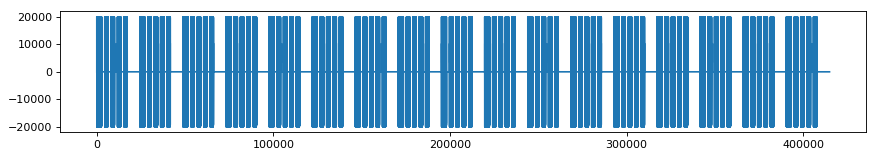

In [9]:
tone = frame([0,1,0,1,0,1,0,1])
for i in range(16):
    tone = append(tone, frame([0,1,0,1,0,1,0,1]))
    
plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameRepeat.wav'
write(WAV_FILE, SAMPLING_RATE, tone)

## Constant tone

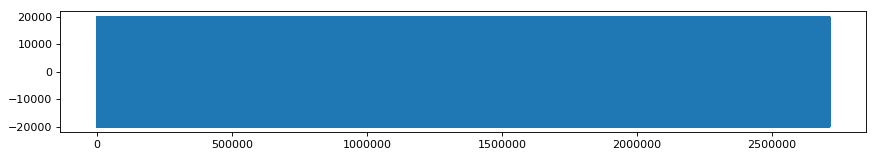

In [12]:
tone = TQ_HIGH;
for i in range(3000):  # approx. 1 min length
    tone = append(tone, TQ_HIGH)
    
plt.figure(figsize=(13, 2), dpi=80)
plt.plot(tone)
WAV_FILE = 'ChirpFrameConstant.wav'
write(WAV_FILE, SAMPLING_RATE, tone)